# Wavelet Tranformation
This juypter notebook is used to understand the Wavelet and its tranformation starting from 2D to a 3D implementation

## Imports

In [1]:
# Usual imports
import matplotlib.pyplot as plt
import numpy as np
import os

# Importing the OpenCV library for image processing
import csv

# Importing the pydicom library for reading dicom files
import pydicom




## Constructing 1D & 2D DWT

In [2]:

def haar_wavelet_1d(signal):
    """Perform 1D Haar Wavelet Transform."""
    n = len(signal)
    
    if n % 2 != 0:
        raise ValueError("Input length must be a power of 2.")
    
    L = np.zeros(n // 2)  # Low-pass coefficients
    H = np.zeros(n // 2)  # High-pass coefficients
    
    for i in range(n // 2):
        # The Low-pass filter L
        L[i] = (signal[2 * i] + signal[2 * i + 1]) / np.sqrt(2)  # Approximation
        # The High-pass filter H
        H[i] = (signal[2 * i] - signal[2 * i + 1]) / np.sqrt(2)  # Detail
        
    return L, H

In [3]:
def haar_wavelet_2d(slice):
    """Perform 2D Haar Wavelet Transform."""
    rows, cols = slice.shape

    if rows % 2 != 0 or cols % 2 != 0:
        raise ValueError("Input dimensions must be even.")

    # Create output arrays
    LL = np.zeros((rows // 2, cols // 2))  # Low-Low coefficients
    LH = np.zeros((rows // 2, cols // 2))  # Low-High coefficients
    HL = np.zeros((rows // 2, cols // 2))  # High-Low coefficients
    HH = np.zeros((rows // 2, cols // 2))  # High-High coefficients

    # Apply 1D Haar transform to rows
    temp = np.zeros_like(slice)
    for i in range(rows):
        L, H = haar_wavelet_1d(slice[i, :])
        temp[i, :cols // 2] = L
        temp[i, cols // 2:] = H

    # Apply 1D Haar transform to columns
    for i in range(cols // 2):
        LL[:, i], LH[:, i] = haar_wavelet_1d(temp[:, i])
        HL[:, i], HH[:, i] = haar_wavelet_1d(temp[:, i + cols // 2])



    return LL, LH, HL, HH


In [4]:
def plot_2d_wavelet_coeffs(LL, LH, HL, HH):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes[0, 0].imshow(LL, cmap='gray')
    axes[0, 0].set_title('LL')
    axes[0, 0].axis('off')
    axes[0, 1].imshow(LH, cmap='gray')
    axes[0, 1].set_title('LH')
    axes[0, 1].axis('off')
    axes[1, 0].imshow(HL, cmap='gray')
    axes[1, 0].set_title('HL')
    axes[1, 0].axis('off')
    axes[1, 1].imshow(HH, cmap='gray')
    axes[1, 1].set_title('HH')
    axes[1, 1].axis('off')
    plt.tight_layout()
    plt.show()

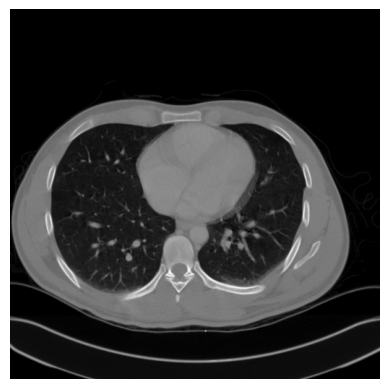

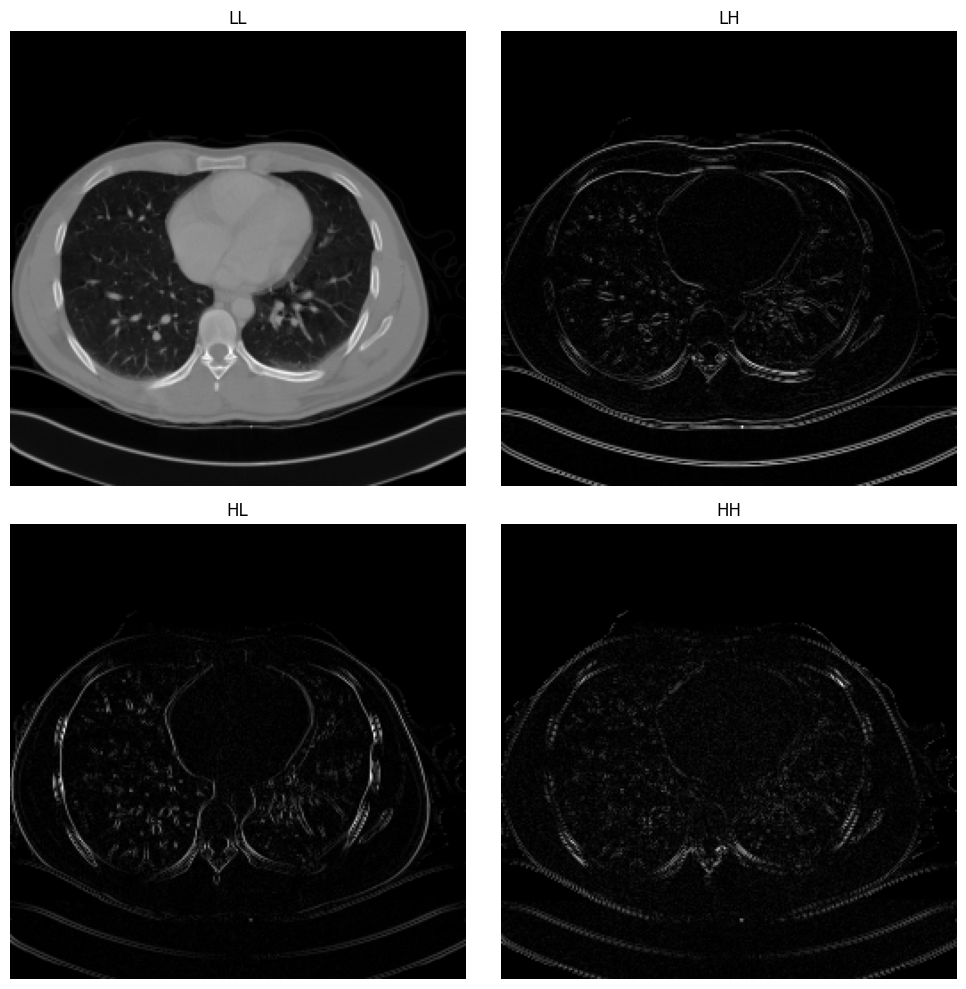

In [5]:
# Path to a DICOM slice
slice_path = "/home/grahampelle/cce3015/assignment-1/CHAOS-Test-Sets/CT/3/DICOM_anon/i0000,0000b.dcm"

# Read the DICOM slice
slice_data = pydicom.dcmread(slice_path).pixel_array

# Normalize the slice data
slice_data = slice_data.astype(np.float32) / np.max(slice_data)

LL, LH, HL, HH = haar_wavelet_2d(slice_data)

# Take the absolute value of the coefficients
LL = np.abs(LL)
LH = np.abs(LH)
HL = np.abs(HL)
HH = np.abs(HH)

# Plot the original slice
plt.imshow(slice_data, cmap='gray')
plt.axis('off')
# Plot the coefficients
plot_2d_wavelet_coeffs(LL, LH, HL, HH)

## Working around for 3D DWT

In [6]:

def haar_wavelet_3d(data):
    """Perform 3D Haar Wavelet Transform."""
    # Read DICOM slices and stack them into a 3D array
    slices = [pydicom.dcmread(file).pixel_array for file in data]

    # Normalize the slices (Only for visualization purposes)
    slices = [slice.astype(np.float32) / np.max(slice) for slice in slices]
    
    # Ensure all slices have the same dimensions
    slice_shape = slices[0].shape
    if not all(slice.shape == slice_shape for slice in slices):
        raise ValueError("All slices must have the same dimensions.")

    # Stack slices into a 3D numpy array
    volume = np.stack(slices)

    # Get the dimensions of the volume
    depth, rows, cols = volume.shape

    if depth % 2 != 0 or rows % 2 != 0 or cols % 2 != 0:
        raise ValueError("Input dimensions must be even for all axes.")

    # Create output arrays for the 3D Haar Transform
    LLL = np.zeros((depth // 2, rows // 2, cols // 2))  # Low-Low-Low coefficients
    LLH = np.zeros((depth // 2, rows // 2, cols // 2))  # Low-Low-High coefficients
    LHL = np.zeros((depth // 2, rows // 2, cols // 2))  # Low-High-Low coefficients
    LHH = np.zeros((depth // 2, rows // 2, cols // 2))  # Low-High-High coefficients
    HLL = np.zeros((depth // 2, rows // 2, cols // 2))  # High-Low-Low coefficients
    HLH = np.zeros((depth // 2, rows // 2, cols // 2))  # High-Low-High coefficients
    HHL = np.zeros((depth // 2, rows // 2, cols // 2))  # High-High-Low coefficients
    HHH = np.zeros((depth // 2, rows // 2, cols // 2))  # High-High-High coefficients

    

    # Apply 2D Haar transform to each slice
    for d in range(depth//2):
        LLL[d], LLH[d], LHL[d], LHH[d] = haar_wavelet_2d(volume[d])
         
        HLL[d], HLH[d], HHL[d], HHH[d] = haar_wavelet_2d(volume[d + depth // 2])


    return LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH

In [7]:

def get_dcm_files(directory):
    # Get all files in the directory
    files = os.listdir(directory)
    # Filter out only .dcm files
    dcm_files = [file for file in files if file.endswith('.dcm')]
    # Sort the files to ensure they are in order
    dcm_files.sort()
    # Get their full paths
    dcm_files = [os.path.join(directory, file) for file in dcm_files]
    return dcm_files


In [8]:
def plot_3d_wavelet_coeffs(LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes[0, 0].imshow(LLL[0], cmap='gray')
    axes[0, 0].set_title('LLL')
    axes[0, 0].axis('off')
    axes[0, 1].imshow(LLH[0], cmap='gray')
    axes[0, 1].set_title('LLH')
    axes[0, 1].axis('off')
    axes[0, 2].imshow(LHL[0], cmap='gray')
    axes[0, 2].set_title('LHL')
    axes[0, 2].axis('off')
    axes[0, 3].imshow(LHH[0], cmap='gray')
    axes[0, 3].set_title('LHH')
    axes[0, 3].axis('off')
    axes[1, 0].imshow(HLL[0], cmap='gray')
    axes[1, 0].set_title('HLL')
    axes[1, 0].axis('off')
    axes[1, 1].imshow(HLH[0], cmap='gray')
    axes[1, 1].set_title('HLH')
    axes[1, 1].axis('off')
    axes[1, 2].imshow(HHL[0], cmap='gray')
    axes[1, 2].set_title('HHL')
    axes[1, 2].axis('off')
    axes[1, 3].imshow(HHH[0], cmap='gray')
    axes[1, 3].set_title('HHH')
    axes[1, 3].axis('off')
    plt.tight_layout()
    plt.show()


In [11]:
# List of DICOM files to read
dicom_files = get_dcm_files("/home/grahampelle/cce3015/assignment-1/CHAOS-Test-Sets/CT/3/DICOM_anon/")

# Perform 3D Haar Wavelet Transform
#LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH = haar_wavelet_3d(dicom_files)

# Take the absolute value of the coefficients
#

# Plot the coefficients
#plot_3d_wavelet_coeffs(LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH)

In [12]:
def load_dicom_files(dicom_files):
    slices = [pydicom.dcmread(file).pixel_array for file in dicom_files]
    return np.stack(slices, axis=-1)


def save_volume_to_csv(volume, csv_file):
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        # Write the shape of the volume as the first row in the order depth, rows, cols
        writer.writerow([volume.shape[2], volume.shape[0], volume.shape[1]])
        # Flatten the volume and write it to the CSV file in depth, rows, cols order
        for d in range(volume.shape[2]):
            for r in range(volume.shape[0]):
                writer.writerow(volume[r, :, d])

In [13]:
# Load the DICOM files into a 3D volume
volume = load_dicom_files(dicom_files)

# Save the volume to a CSV file
csv_file = 'volume.csv'
save_volume_to_csv(volume, csv_file)

In [14]:

def read_wavelet_coeffs_from_csv(csv_file):
    with open(csv_file, 'r') as file:
        reader = csv.reader(file, delimiter=' ')
        
        # Read the shape of the volume from the first row
        depth, rows, cols = map(int, next(reader))
        
        # Initialize the LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH arrays
        LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH = [np.zeros((depth, rows, cols), dtype=np.float32) for _ in range(8)]
        
        # Read the wavelet coefficients from the CSV file
        current_array = None
        depth_index = 0
        for line in reader:
            if line[0] in ['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH']:
                current_array = line[0]
                depth_index = 0
                print(f"Switching to array: {current_array}")  # Debugging output
                continue
            
            if current_array is not None:
                # Debugging output to show the row being read
                #print(f"Reading row at depth {depth_index // rows}, row {depth_index % rows} for {current_array}: {line}")
                # Remove any empty strings or extra spaces
                row_values = [value for value in line if value]
                if len(row_values) != cols:
                    raise ValueError(f"Expected {cols} columns, but got {len(row_values)} columns in row at depth {depth_index // rows}, row {depth_index % rows} for {current_array}")
                row_values = list(map(float, row_values))
                if current_array == 'LLL':
                    LLL[depth_index // rows, depth_index % rows, :] = row_values
                elif current_array == 'LLH':
                    LLH[depth_index // rows, depth_index % rows, :] = row_values
                elif current_array == 'LHL':
                    LHL[depth_index // rows, depth_index % rows, :] = row_values
                elif current_array == 'LHH':
                    LHH[depth_index // rows, depth_index % rows, :] = row_values
                elif current_array == 'HLL':
                    HLL[depth_index // rows, depth_index % rows, :] = row_values
                elif current_array == 'HLH':
                    HLH[depth_index // rows, depth_index % rows, :] = row_values
                elif current_array == 'HHL':
                    HHL[depth_index // rows, depth_index % rows, :] = row_values
                elif current_array == 'HHH':
                    HHH[depth_index // rows, depth_index % rows, :] = row_values
                depth_index += 1
        
    return LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH


Switching to array: LLL
Switching to array: LLH
Switching to array: LHL
Switching to array: LHH
Switching to array: HLL
Switching to array: HLH
Switching to array: HHL
Switching to array: HHH


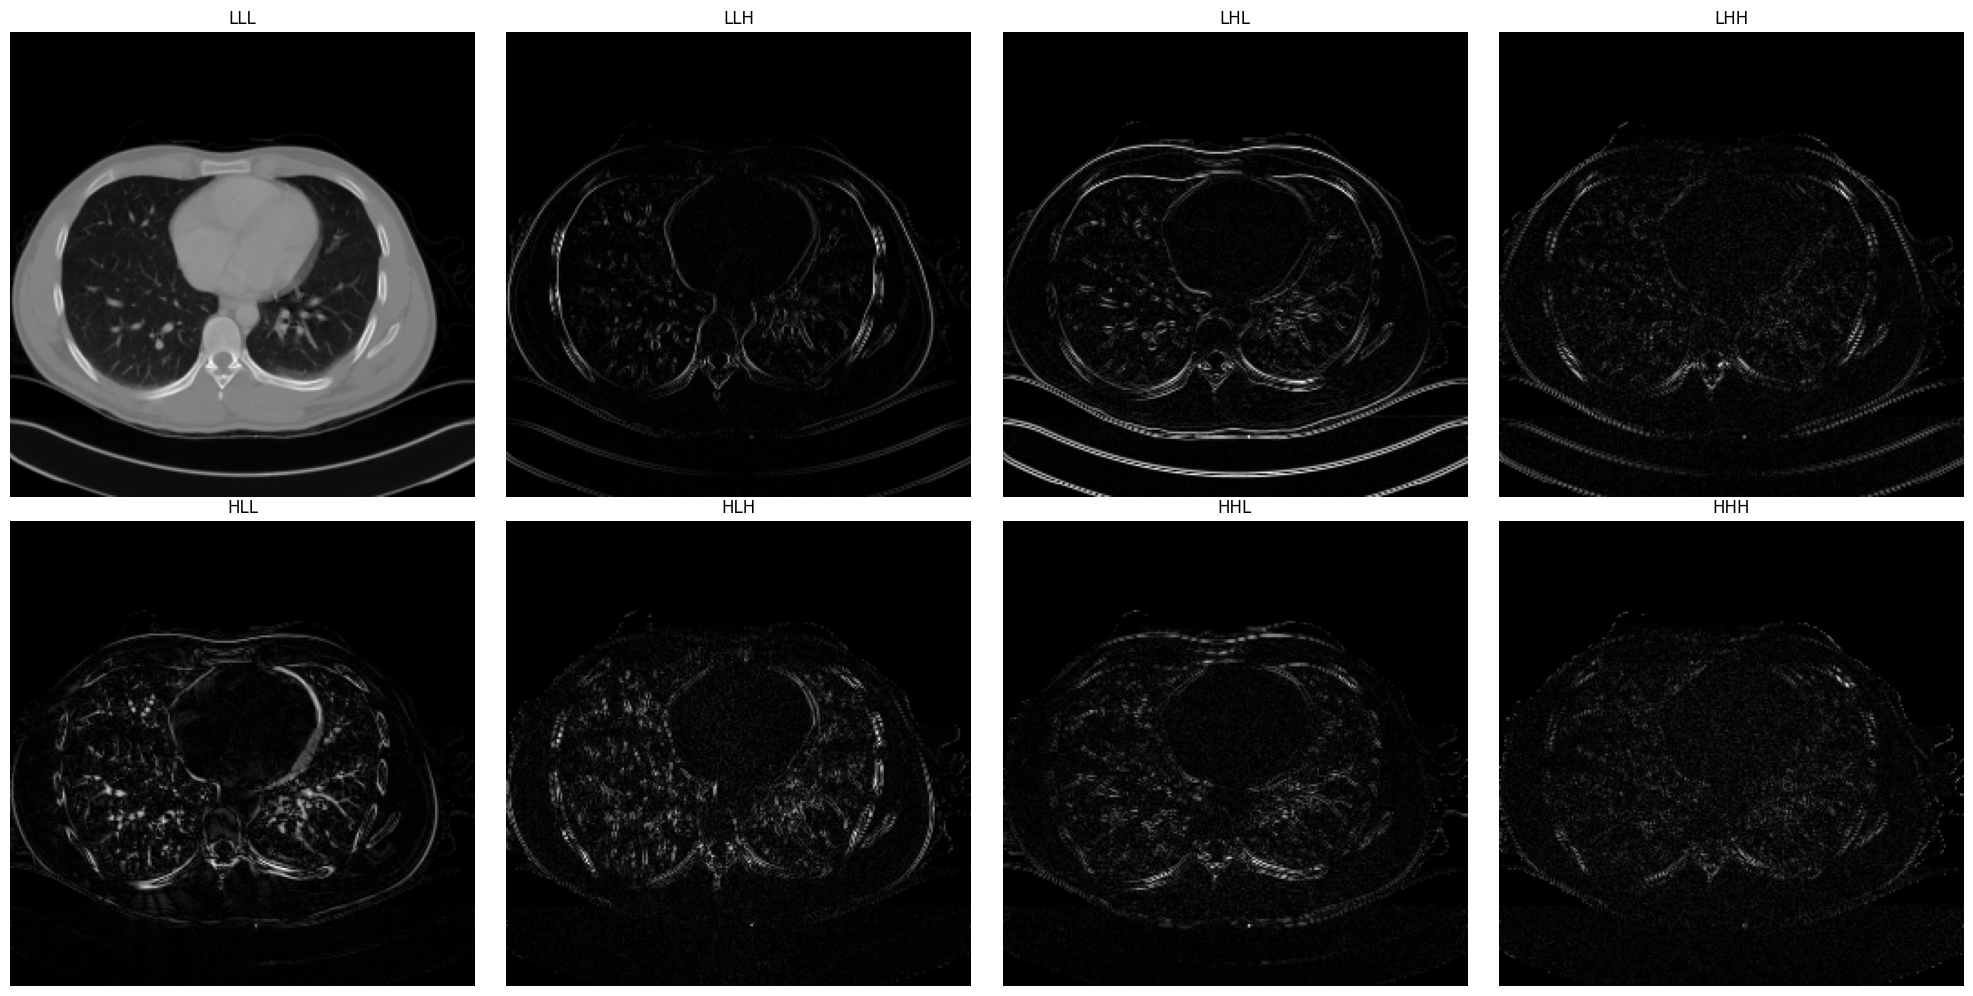

In [25]:

# Example usage
csv_file = "/home/grahampelle/cce3015/assignment-1/output.csv"
LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH = read_wavelet_coeffs_from_csv(csv_file)

# Take the absolute value of the coefficients
LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH = [np.abs(coeff) for coeff in [LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH]]

# Plot the coefficients
plot_3d_wavelet_coeffs(LLL, LLH, LHL, LHH, HLL, HLH, HHL, HHH)
